In [1]:
# import necessary library
import pandas as pd
import math
import seaborn as sns
from matplotlib import pyplot as plt
import re
import numpy as np
import geopandas as gpd
from shapely.geometry import Point # Point class
from shapely.geometry import shape
import networkx as nx
import osmnx as ox
import os 
from geopandas import GeoDataFrame, read_file
from geopandas.tools import overlay
import shapely.geometry as geom
import shapely.wkt

C:\Users\Md Mintu Miah\anaconda3\envs\geo_env\lib\site-packages\geopandas\_compat.py:112: UserWarning: The Shapely GEOS version (3.11.0-CAPI-1.17.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
# Helper Function
def min_distance_ppoly(point, polygon):
    return polygon.distance(point).min()

In [3]:
# read the shprt term sites count data from 2016 to 2019
sc=pd.read_csv('C:/UC Berkeley Project Backup/Bike_ped Exposure Model Project/Processed Data/short_term_clean_data_2016_2019.csv')

In [4]:
sc['Count'].describe()

count    32109.000000
mean        10.709988
std         21.411523
min          0.000000
25%          2.000000
50%          5.000000
75%         12.000000
max       1141.000000
Name: Count, dtype: float64

In [5]:
sc['Leg'].replace({None: 'unknown'},inplace =True)
sc['matched_seg_id'].replace({None: 'unknown'},inplace =True)

In [6]:
sc.head()

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,ID,Date,Day of Week,Start Time,End Time,Count,Leg,...,dayofweek,weekday_Status,Week Day Status,starttime,endtime,starttime1,endtime1,startDateTime,endDateTime,diff
0,3432,3432,0,CH0,2018-05-30,Wednesday,7:00 AM,8:00 AM,4,N,...,2.0,0,Week Day,07:00:00,08:00:00,NaN,NaN,2018-05-30 07:00:00,2018-05-30 08:00:00,1.0
1,3433,3433,1,CH0,2018-05-30,Wednesday,8:00 AM,9:00 AM,4,N,...,2.0,0,Week Day,08:00:00,09:00:00,NaN,NaN,2018-05-30 08:00:00,2018-05-30 09:00:00,1.0
2,3438,3438,6,CH0,2018-05-30,Wednesday,7:00 AM,8:00 AM,1,E,...,2.0,0,Week Day,07:00:00,08:00:00,NaN,NaN,2018-05-30 07:00:00,2018-05-30 08:00:00,1.0
3,3442,3442,10,CH0,2018-05-30,Wednesday,7:00 AM,8:00 AM,3,S,...,2.0,0,Week Day,07:00:00,08:00:00,NaN,NaN,2018-05-30 07:00:00,2018-05-30 08:00:00,1.0
4,3443,3443,11,CH0,2018-05-30,Wednesday,8:00 AM,9:00 AM,4,S,...,2.0,0,Week Day,08:00:00,09:00:00,NaN,NaN,2018-05-30 08:00:00,2018-05-30 09:00:00,1.0


In [7]:
check=sc.loc[sc['Count']>500]
check

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,ID,Date,Day of Week,Start Time,End Time,Count,Leg,...,dayofweek,weekday_Status,Week Day Status,starttime,endtime,starttime1,endtime1,startDateTime,endDateTime,diff
8023,32670,32670,2495,Miovision81,2017-06-04,Sunday,6:00 AM,7:00 AM,1141,N,...,6.0,1,Weekend,06:00:00,07:00:00,NaN,NaN,2017-06-04 06:00:00,2017-06-04 07:00:00,1.0
8024,32671,32671,2496,Miovision81,2017-06-04,Sunday,7:00 AM,8:00 AM,1081,N,...,6.0,1,Weekend,07:00:00,08:00:00,NaN,NaN,2017-06-04 07:00:00,2017-06-04 08:00:00,1.0
8032,32691,32691,2516,Miovision81,2017-06-04,Sunday,6:00 AM,7:00 AM,1140,S,...,6.0,1,Weekend,06:00:00,07:00:00,NaN,NaN,2017-06-04 06:00:00,2017-06-04 07:00:00,1.0
8033,32692,32692,2517,Miovision81,2017-06-04,Sunday,7:00 AM,8:00 AM,1081,S,...,6.0,1,Weekend,07:00:00,08:00:00,NaN,NaN,2017-06-04 07:00:00,2017-06-04 08:00:00,1.0


In [8]:
sc.columns

Index(['Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0', 'ID', 'Date',
       'Day of Week', 'Start Time', 'End Time', 'Count', 'Leg',
       'matched_seg_id', 'date', 'month', 'year', 'day', 'dayofweek',
       'weekday_Status', 'Week Day Status', 'starttime', 'endtime',
       'starttime1', 'endtime1', 'startDateTime', 'endDateTime', 'diff'],
      dtype='object')

In [9]:
#sc['Leg'].isnull().sum()
sc['matched_seg_id'].isnull().sum()

0

In [10]:
sc['Leg'].unique()

array(['N', 'E', 'S', 'W', 'unknown', 'NE', 'NW'], dtype=object)

In [11]:
# Winter: Dec, Jan, feb
# spring- March, April, May
#summer- June, july and August
# Autumn- Spetember, October, November

In [12]:
# check the seasonal data collection
winter_mask=sc['month'].isin([12, 1,2])
winter=sc[winter_mask]
spring_mask=sc['month'].isin([3, 4,5])
spring=sc[spring_mask]
summer_mask=sc['month'].isin([6, 7,8])
summer=sc[summer_mask]
autumn_mask=sc['month'].isin([9, 10,11])
autumn=sc[autumn_mask]
autumn.head()

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,ID,Date,Day of Week,Start Time,End Time,Count,Leg,...,dayofweek,weekday_Status,Week Day Status,starttime,endtime,starttime1,endtime1,startDateTime,endDateTime,diff
245,4078,4078,0,Davis0,2016-11-15,Tuesday,11:00 AM,12:00 PM,119,N,...,1.0,0,Week Day,11:00:00,12:00:00,NaN,NaN,2016-11-15 11:00:00,2016-11-15 12:00:00,1.0
246,4080,4080,2,Davis0,2016-11-15,Tuesday,11:00 AM,12:00 PM,41,E,...,1.0,0,Week Day,11:00:00,12:00:00,NaN,NaN,2016-11-15 11:00:00,2016-11-15 12:00:00,1.0
247,4082,4082,4,Davis0,2016-11-15,Tuesday,11:00 AM,12:00 PM,127,S,...,1.0,0,Week Day,11:00:00,12:00:00,NaN,NaN,2016-11-15 11:00:00,2016-11-15 12:00:00,1.0
248,4084,4084,6,Davis0,2016-11-15,Tuesday,11:00 AM,12:00 PM,23,W,...,1.0,0,Week Day,11:00:00,12:00:00,NaN,NaN,2016-11-15 11:00:00,2016-11-15 12:00:00,1.0
249,4086,4086,8,Davis1,2016-11-15,Tuesday,11:00 AM,12:00 PM,85,N,...,1.0,0,Week Day,11:00:00,12:00:00,NaN,NaN,2016-11-15 11:00:00,2016-11-15 12:00:00,1.0


In [13]:
print('winter sites', winter['ID'].nunique())
print('spring sites', spring['ID'].nunique())
print('summer sites', summer['ID'].nunique())
print('autumn sites', autumn['ID'].nunique())

winter sites 550
spring sites 612
summer sites 305
autumn sites 882


In [14]:
# sites collected data in saturdaya nd sunday
sat_sun=sc.loc[sc['Week Day Status']=='Weekend']
sat_sun['ID'].nunique()

161

In [15]:
# Sites collected data from monday to friday
mon_fri=sc.loc[sc['Week Day Status']=='Week Day']
mon_fri['ID'].nunique()

2106

In [16]:
# unique number of sites
sc['ID'].nunique()

2256

In [17]:
# bring the lat and long
location=pd.read_csv('C:/UC Berkeley Project Backup/Bike_ped Exposure Model Project/Processed Data/SMART3_locations_20201130.csv',encoding='cp1252')
#location['RecentYear'] = location['RecentYear'].apply(np.int64)
location=location.rename(columns={'Study_ID':'ID'})
location.head()

,OBJECTID,Source,ID,Intersection,City,County,State,RecentYear,Lat,Long,Inter_ID,Segment
0,1,G:\TSC\Grants\G2018_SMART3\Data\Counts\Alameda...,AC130,HILLEGASS AVENUE & ASHBY AVENUE,BERKELEY,NaN,CA,2012.0,37.85673,-122.25550,198.0,0
1,2,G:\TSC\Grants\G2018_SMART3\Data\Counts\Alameda...,AC134,SAN PABLO AVENUE & VIRGINIA STREET,BERKELEY,NaN,CA,2012.0,37.87345,-122.29348,117.0,0
2,3,G:\TSC\Grants\G2018_SMART3\Data\Counts\Alameda...,AC143,FREMONT BOULEVARD & MOWRY AVENUE,FREMONT,NaN,CA,2012.0,37.54854,-121.98838,427.0,0
3,4,G:\TSC\Grants\G2018_SMART3\Data\Counts\Alameda...,AC139,HACIENDA BOULEVARD & DUBLIN BOULEVARD,DUBLIN,NaN,CA,2012.0,37.70617,-121.88823,485.0,0
4,5,G:\TSC\Grants\G2018_SMART3\Data\Counts\Alameda...,AC136,MISSION BOUELVARD (CA 185) & GROVE WAY,CHERRYLAND,NaN,CA,2012.0,37.68037,-122.09406,332.0,0


In [18]:
location1=location[['ID', 'Lat', 'Long']]
location1.head()

,ID,Lat,Long
0,AC130,37.85673,-122.25550
1,AC134,37.87345,-122.29348
2,AC143,37.54854,-121.98838
3,AC139,37.70617,-121.88823
4,AC136,37.68037,-122.09406


In [19]:
# Import additional short term location
add_short=gpd.read_file('C:/UC Berkeley Project Backup/Bike_ped Exposure Model Project/ForMintu/ForMintu/sc_missing.shp')
add_short=add_short.to_crs('epsg:4326')
add_short["Long"] = add_short.centroid.x
add_short["Lat"] =add_short.centroid.y
add_short1=add_short[['ID','Lat', 'Long']]
#add_short1=add_short1.rename(columns={'syear':'year'})
add_short1.head()

C:\Users\Md Mintu Miah\AppData\Local\Temp\ipykernel_20156\1682324396.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  add_short["Long"] = add_short.centroid.x
C:\Users\Md Mintu Miah\AppData\Local\Temp\ipykernel_20156\1682324396.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  add_short["Lat"] =add_short.centroid.y


,ID,Lat,Long
0,Kern559,35.594292,-119.352602
1,Kern564,35.593596,-119.345930
2,Kern424,35.055011,-118.173788
3,Kern421,35.050387,-118.173000
4,Kern422,35.052933,-118.173819


In [20]:
c=add_short1.loc[add_short1["ID"]=='Kern504']
c

,ID,Lat,Long
500,Kern504,35.187839,-118.833041


In [21]:
# Combine all short term togther
short_all=pd.concat([location1,add_short1],axis=0)
short_all.head()

,ID,Lat,Long
0,AC130,37.85673,-122.25550
1,AC134,37.87345,-122.29348
2,AC143,37.54854,-121.98838
3,AC139,37.70617,-121.88823
4,AC136,37.68037,-122.09406


In [22]:
short_all['ID'].nunique()

4740

In [23]:
sc['ID'].nunique(), sc.shape

(2256, (32109, 25))

In [24]:
# jpin short term counts sites data with location
sc_loc=pd.merge(sc, short_all, left_on=['ID'], right_on=['ID'], how='inner')
sc_loc.tail()

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,ID,Date,Day of Week,Start Time,End Time,Count,Leg,...,Week Day Status,starttime,endtime,starttime1,endtime1,startDateTime,endDateTime,diff,Lat,Long
30689,43867,43867,13692,Eric_Fischer1111,2016-06-07,Tuesday,16:00,17:00,3,N,...,Week Day,16:00:00,17:00:00,NaN,NaN,2016-06-07 16:00:00,2016-06-07 17:00:00,1.0,34.220200,-118.571035
30690,43868,43868,13693,Eric_Fischer1111,2016-06-07,Tuesday,16:00,17:00,3,S,...,Week Day,16:00:00,17:00:00,NaN,NaN,2016-06-07 16:00:00,2016-06-07 17:00:00,1.0,34.220200,-118.571035
30691,43869,43869,13694,Eric_Fischer1111,2016-06-07,Tuesday,16:00,17:00,2,W,...,Week Day,16:00:00,17:00:00,NaN,NaN,2016-06-07 16:00:00,2016-06-07 17:00:00,1.0,34.220200,-118.571035
30692,43870,43870,13695,Eric_Fischer1112,2016-06-07,Tuesday,16:00,17:00,3,N,...,Week Day,16:00:00,17:00:00,NaN,NaN,2016-06-07 16:00:00,2016-06-07 17:00:00,1.0,34.130331,-118.460759
30693,43871,43871,13696,Eric_Fischer1112,2016-06-07,Tuesday,16:00,17:00,2,S,...,Week Day,16:00:00,17:00:00,NaN,NaN,2016-06-07 16:00:00,2016-06-07 17:00:00,1.0,34.130331,-118.460759


In [25]:
sc_loc.shape

(30694, 27)

In [26]:
sc['ID'].nunique(),sc_loc['ID'].nunique()

(2256, 2129)

In [27]:
# export useable unique short term sites
sc_loc_unique=sc_loc.drop_duplicates(subset=['ID'], keep='first')
sc_loc_unique.to_csv('C:/UC Berkeley Project Backup/Bike_ped Exposure Model Project/Processed Data/SC_with_Valid_loc.csv')

In [28]:
# First Separate the counters by weekday and weekend, then Calculate the Max AMI and PMI

In [29]:
sc_loc.columns

Index(['Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0', 'ID', 'Date',
       'Day of Week', 'Start Time', 'End Time', 'Count', 'Leg',
       'matched_seg_id', 'date', 'month', 'year', 'day', 'dayofweek',
       'weekday_Status', 'Week Day Status', 'starttime', 'endtime',
       'starttime1', 'endtime1', 'startDateTime', 'endDateTime', 'diff', 'Lat',
       'Long'],
      dtype='object')

#  Imput weekday Daily Volume

In [30]:
# weekend=1 and weekday=0
weekend_hr_data=sc_loc.loc[sc_loc['weekday_Status']==1]
weekday_hr_data=sc_loc.loc[sc_loc['weekday_Status']==0]
weekday_hr_data.head()

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,ID,Date,Day of Week,Start Time,End Time,Count,Leg,...,Week Day Status,starttime,endtime,starttime1,endtime1,startDateTime,endDateTime,diff,Lat,Long
0,3432,3432,0,CH0,2018-05-30,Wednesday,7:00 AM,8:00 AM,4,N,...,Week Day,07:00:00,08:00:00,NaN,NaN,2018-05-30 07:00:00,2018-05-30 08:00:00,1.0,38.71844,-121.29042
1,3433,3433,1,CH0,2018-05-30,Wednesday,8:00 AM,9:00 AM,4,N,...,Week Day,08:00:00,09:00:00,NaN,NaN,2018-05-30 08:00:00,2018-05-30 09:00:00,1.0,38.71844,-121.29042
2,3438,3438,6,CH0,2018-05-30,Wednesday,7:00 AM,8:00 AM,1,E,...,Week Day,07:00:00,08:00:00,NaN,NaN,2018-05-30 07:00:00,2018-05-30 08:00:00,1.0,38.71844,-121.29042
3,3442,3442,10,CH0,2018-05-30,Wednesday,7:00 AM,8:00 AM,3,S,...,Week Day,07:00:00,08:00:00,NaN,NaN,2018-05-30 07:00:00,2018-05-30 08:00:00,1.0,38.71844,-121.29042
4,3443,3443,11,CH0,2018-05-30,Wednesday,8:00 AM,9:00 AM,4,S,...,Week Day,08:00:00,09:00:00,NaN,NaN,2018-05-30 08:00:00,2018-05-30 09:00:00,1.0,38.71844,-121.29042


In [31]:
weekday_hr_data['ID'].nunique(),weekend_hr_data['ID'].nunique()

(1992, 148)

In [32]:
# Calculate AM Count by eco id
weekday_am1=weekday_hr_data[(weekday_hr_data['starttime']=='07:00:00')]
weekday_am2=weekday_hr_data[(weekday_hr_data['starttime']=='08:00:00')]
weekday_am=pd.concat([weekday_am1,weekday_am2],axis=0)
#df181amg=df181am.groupby(['ID'])['Bicycle Count'].sum()
df181amg=pd.DataFrame({'AM_count' : weekday_am.groupby(['ID','year','Leg'])['Count'].sum()}).reset_index()

# Calculate pM count by Eco ID
weekday_pm1=weekday_hr_data[(weekday_hr_data['starttime']=='11:00:00')]
weekday_pm2=weekday_hr_data[(weekday_hr_data['starttime']=='12:00:00')]
df181pm=pd.concat([weekday_pm1,weekday_pm2],axis=0)
#df181amg=df181am.groupby(['ID'])['Bicycle Count'].sum()
df181pmg=pd.DataFrame({'PM_count' : df181pm.groupby(['ID','year','Leg'])['Count'].sum()}).reset_index()

# Join am and Pm count by eco id
df181_am_pm=pd.merge(df181amg,df181pmg,left_on=['ID','year','Leg'],right_on=['ID','year','Leg'],how='inner')
# Calculate the AMI
df181_am_pm['AMI']=df181_am_pm['AM_count']/df181_am_pm['PM_count']
df181_am_pm.head()

,ID,year,Leg,AM_count,PM_count,AMI
0,CH11,2019.0,E,4,2,2.0
1,CH11,2019.0,W,4,1,4.0
2,CH13,2019.0,E,7,1,7.0
3,CH13,2019.0,W,7,1,7.0
4,CH15,2019.0,E,7,5,1.4


In [33]:
df181_am_pm['ID'].nunique()

701

In [34]:
df181_am_pm.groupby(['year','Leg'])['ID'].count()

year    Leg    
2016.0  E          119
        N          126
        S          121
        W          100
        unknown    111
2017.0  E           21
        N           46
        S           34
        W           22
        unknown      1
2018.0  E           62
        N           52
        S           49
        W           37
2019.0  E           74
        N           68
        S           57
        W           64
        unknown      5
Name: ID, dtype: int64

In [35]:
# Calculate AM Count by eco id
df181pm1=weekday_hr_data[(weekday_hr_data['starttime']=='17:00:00')]
df181pm2=weekday_hr_data[(weekday_hr_data['starttime']=='18:00:00')]
df181pm=pd.concat([df181pm1,df181pm2],axis=0)
#df181amg=df181am.groupby(['ID'])['Bicycle Count'].sum()
df181pmg=pd.DataFrame({'late_PM_count' : df181pm.groupby(['ID','year','Leg'])['Count'].sum()}).reset_index()

# Calculate pM count by Eco ID
df181pm2g1=weekday_hr_data[(weekday_hr_data['starttime']=='11:00:00')]
df181pm2g2=weekday_hr_data[(weekday_hr_data['starttime']=='12:00:00')]
df181pm2g=pd.concat([df181pm2g1,df181pm2g2],axis=0)
#df181amg=df181am.groupby(['ID'])['Bicycle Count'].sum()
df181pm2g=pd.DataFrame({'early_PM_count' : df181pm2g.groupby(['ID','year','Leg'])['Count'].sum()}).reset_index()

# Join am and Pm count by eco id
df181_pm_pm=pd.merge(df181pmg,df181pm2g,left_on=['ID','year','Leg'],right_on=['ID','year','Leg'],how='inner')
# Calculate the AMI
df181_pm_pm['PMI']=df181_pm_pm['late_PM_count']/df181_pm_pm['early_PM_count']
df181_pm_pm.head()

,ID,year,Leg,late_PM_count,early_PM_count,PMI
0,AC20160,2016.0,E,7,2,3.500000
1,AC20160,2016.0,N,4,4,1.000000
2,AC20160,2016.0,S,8,3,2.666667
3,AC20160,2016.0,W,13,5,2.600000
4,AC201610,2016.0,E,22,7,3.142857


In [36]:
df181_pm_pm['ID'].nunique()

661

In [37]:
df181_pm_pm.groupby(['year','Leg'])['ID'].count()

year    Leg    
2016.0  E           61
        N           57
        S           56
        W           51
        unknown    115
2017.0  E           33
        N           54
        S           39
        W           32
        unknown      2
2018.0  E           83
        N           73
        NW           1
        S           73
        W           61
        unknown      2
2019.0  E           76
        N           65
        S           54
        W           72
        unknown      4
Name: ID, dtype: int64

In [38]:
AMI_PMI=pd.merge(df181_am_pm,df181_pm_pm, left_on=['ID','year','Leg'], right_on=['ID','year','Leg'], how='inner')
AMI_PMI.head(10)

,ID,year,Leg,AM_count,PM_count,AMI,late_PM_count,early_PM_count,PMI
0,CH11,2019.0,E,4,2,2.000000,4,2,2.000000
1,CH11,2019.0,W,4,1,4.000000,2,1,2.000000
2,CH13,2019.0,E,7,1,7.000000,1,1,1.000000
3,CH13,2019.0,W,7,1,7.000000,1,1,1.000000
4,CH15,2019.0,E,7,5,1.400000,2,5,0.400000
5,CH15,2019.0,W,7,2,3.500000,2,2,1.000000
6,CH17,2019.0,E,7,9,0.777778,6,9,0.666667
7,CH17,2019.0,N,4,4,1.000000,2,4,0.500000
8,CH17,2019.0,S,3,3,1.000000,2,3,0.666667
9,CH17,2019.0,W,10,7,1.428571,8,7,1.142857


In [39]:
AMI_PMI.shape,AMI_PMI["ID"].nunique()

((780, 9), 572)

In [40]:
AMI_PMI['ID'].nunique()

572

In [41]:
# mask=sc['ID'].isin(location['Study_ID'])
# sc_mis=sc[mask]
# sc_mis.shape

In [42]:
# expoort short term location with missing lat and long
# sc_m=sc[~sc.ID.isin(location.Study_ID)]
# sc_m1=sc_m.drop_duplicates(subset=['ID','Leg','year'], keep='first')
# sc_m1.columns

In [43]:
# sc_m2=sc_m1[['ID', 'year','Leg','matched_seg_id']]
# sc_m2.shape

In [44]:
# sc_m2.to_csv('C:/UC Berkeley Project Backup/Bike_ped Exposure Model Project/Processed Data/SC_with_missing_location.csv')

In [45]:
# Calculate the max AMI_PMI Value
def max_weekday_value(Max_weekday_AMI,Max_weekday_PMI):
    if Max_weekday_AMI>Max_weekday_PMI:
        return Max_weekday_AMI
    else:
        return Max_weekday_PMI

In [46]:
AMI_PMI['Max_AMI_PMI']=AMI_PMI.apply(lambda row:max_weekday_value(row['AMI'],row['PMI']),axis=1)
AMI_PMI1=AMI_PMI[['ID','year','Leg','Max_AMI_PMI']]
AMI_PMI2=pd.merge(weekday_hr_data,AMI_PMI1,on=['ID','year','Leg'], how='inner')
AMI_PMI2.head()

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,ID,Date,Day of Week,Start Time,End Time,Count,Leg,...,starttime,endtime,starttime1,endtime1,startDateTime,endDateTime,diff,Lat,Long,Max_AMI_PMI
0,3489,3489,57,CH3,2019-01-23,Wednesday,4:00 AM,5:00 AM,1,E,...,04:00:00,05:00:00,NaN,NaN,2019-01-23 04:00:00,2019-01-23 05:00:00,1.0,38.70285,-121.27365,1.1
1,3490,3490,58,CH3,2019-01-23,Wednesday,5:00 AM,6:00 AM,1,E,...,05:00:00,06:00:00,NaN,NaN,2019-01-23 05:00:00,2019-01-23 06:00:00,1.0,38.70285,-121.27365,1.1
2,3491,3491,59,CH3,2019-01-23,Wednesday,6:00 AM,7:00 AM,1,E,...,06:00:00,07:00:00,NaN,NaN,2019-01-23 06:00:00,2019-01-23 07:00:00,1.0,38.70285,-121.27365,1.1
3,3492,3492,60,CH3,2019-01-23,Wednesday,7:00 AM,8:00 AM,3,E,...,07:00:00,08:00:00,NaN,NaN,2019-01-23 07:00:00,2019-01-23 08:00:00,1.0,38.70285,-121.27365,1.1
4,3493,3493,61,CH3,2019-01-23,Wednesday,8:00 AM,9:00 AM,4,E,...,08:00:00,09:00:00,NaN,NaN,2019-01-23 08:00:00,2019-01-23 09:00:00,1.0,38.70285,-121.27365,1.1


In [47]:
AMI_PMI2.shape

(12376, 28)

In [48]:
AMI_PMI2=AMI_PMI2.drop_duplicates(subset=['ID','year','month','day','Leg','Day of Week','matched_seg_id','Lat','Long','starttime'], keep='first')

In [49]:
AMI_PMI2.shape

(11219, 28)

In [50]:
AMI_PMI.groupby(['year','Leg'])['ID'].count()

year    Leg    
2016.0  E           42
        N           33
        S           32
        W           32
        unknown    111
2017.0  E           19
        N           43
        S           30
        W           18
        unknown      1
2018.0  E           54
        N           47
        S           45
        W           33
2019.0  E           70
        N           59
        S           47
        W           60
        unknown      4
Name: ID, dtype: int64

In [51]:
AMI_PMI.groupby(['year'])['ID'].count()

year
2016.0    250
2017.0    111
2018.0    179
2019.0    240
Name: ID, dtype: int64

In [52]:
# split the data by Max_AMI_PMI Value
AMI_PMI2_g1=AMI_PMI2.loc[AMI_PMI2['Max_AMI_PMI']<=1]
AMI_PMI2_g1=AMI_PMI2_g1.drop(['Unnamed: 0.2','Unnamed: 0.1','Unnamed: 0','Start Time', 'End Time', 'starttime1', 'endtime1','startDateTime',
       'endDateTime'],axis=1)
AMI_PMI2_g2=AMI_PMI2[(AMI_PMI2.Max_AMI_PMI>1) &(AMI_PMI2.Max_AMI_PMI<=2.50)]
AMI_PMI2_g3=AMI_PMI2.loc[AMI_PMI2['Max_AMI_PMI']>2.50]

In [53]:
#AMI_PMI2_g1.loc[AMI_PMI2_g1['ID']=='Kern125']

In [54]:
AMI_PMI1.shape,AMI_PMI2.shape

((780, 4), (11219, 28))

In [55]:
# read the HOD factor for weekday and group it by criteria
HOD=pd.read_csv('C:/UC Berkeley Project Backup/Bike_ped Exposure Model Project/Final Factor/Final_HOD_Factor.csv')
HOD_weekday=HOD.loc[HOD['day_of_status']=='weekday']
HOD_weekday_g1=HOD_weekday.loc[HOD_weekday['Criteria']=='Max_AMI_PMI<=1']
HOD_weekday_g2=HOD_weekday.loc[HOD_weekday['Criteria']=='1<Max_AMI_PMI<=2.5']
HOD_weekday_g3=HOD_weekday.loc[HOD_weekday['Criteria']=='Max_AMI_PMI>2.5']

In [56]:
HOD_weekday_g1.head()

,Unnamed: 0,starttime,Average_Group_HOD_Factor,Criteria,day_of_status
0,0,00:00:00,0.002970,Max_AMI_PMI<=1,weekday
1,1,01:00:00,0.002145,Max_AMI_PMI<=1,weekday
2,2,02:00:00,0.001953,Max_AMI_PMI<=1,weekday
3,3,03:00:00,0.001807,Max_AMI_PMI<=1,weekday
4,4,04:00:00,0.002084,Max_AMI_PMI<=1,weekday


In [57]:
# Calculate daily Volume for group 1
g1_DV=pd.merge(AMI_PMI2_g1,HOD_weekday_g1, on=['starttime'], how='inner')
g1_DV1=pd.DataFrame({'agge_count' : g1_DV.groupby(['ID','year','month','day','Leg','Day of Week','matched_seg_id','Lat','Long'])['Count'].sum()}).reset_index()
g1_DV1f=pd.DataFrame({'agge_factor' : g1_DV.groupby(['ID','year','month','day','Leg','Day of Week','matched_seg_id','Lat','Long'])['Average_Group_HOD_Factor'].sum()}).reset_index()
g1_DV1r=pd.merge(g1_DV1,g1_DV1f, on=['ID','year','month','day','Leg','Day of Week','matched_seg_id','Lat','Long'], how='inner')
g1_DV1r['Daily_Volume']=g1_DV1r['agge_count']/g1_DV1r['agge_factor']
g1_DV1rf=pd.DataFrame({'TDV' : g1_DV1r.groupby(['ID','year','Leg','Day of Week','month','matched_seg_id','Lat','Long'])['Daily_Volume'].mean()}).reset_index()

In [58]:
g1_DV1.shape,g1_DV1r.shape

((355, 10), (355, 12))

In [59]:
c=g1_DV.loc[g1_DV['Count']==0]
c1=g1_DV1.loc[g1_DV1['agge_count']==0]
c.shape,c1.shape

((0, 23), (0, 10))

In [60]:
# Calculate daily Volume for group 2
g2_DV=pd.merge(AMI_PMI2_g2,HOD_weekday_g2, on=['starttime'], how='inner')
g2_DV2=pd.DataFrame({'agge_count' : g2_DV.groupby(['ID','year','month','day','Leg','Day of Week','matched_seg_id','Lat','Long'])['Count'].sum()}).reset_index()
g2_DV2f=pd.DataFrame({'agge_factor' : g2_DV.groupby(['ID','year','month','day','Leg','Day of Week','matched_seg_id','Lat','Long'])['Average_Group_HOD_Factor'].sum()}).reset_index()
g2_DV2r=pd.merge(g2_DV2,g2_DV2f, on=['ID','year','month','day','Leg','Day of Week','matched_seg_id','Lat','Long'], how='inner')
g2_DV2r['Daily_Volume']=g2_DV2r['agge_count']/g2_DV2r['agge_factor']
g2_DV2rf=pd.DataFrame({'TDV' : g2_DV2r.groupby(['ID','year','Leg','Day of Week','month','matched_seg_id','Lat','Long'])['Daily_Volume'].mean()}).reset_index()

In [61]:
g2_DV2.shape,g2_DV2r.shape

((341, 10), (341, 12))

In [62]:
# Calculate daily Volume for group 3
g3_DV=pd.merge(AMI_PMI2_g3,HOD_weekday_g3, on=['starttime'], how='inner')
g3_DV3=pd.DataFrame({'agge_count' : g3_DV.groupby(['ID','year','month','day','Leg','Day of Week','matched_seg_id','Lat','Long'])['Count'].sum()}).reset_index()
g3_DV3f=pd.DataFrame({'agge_factor' : g3_DV.groupby(['ID','year','month','day','Leg','Day of Week','matched_seg_id','Lat','Long'])['Average_Group_HOD_Factor'].sum()}).reset_index()
g3_DV3r=pd.merge(g3_DV3,g3_DV3f, on=['ID','year','month','day','Leg','Day of Week','matched_seg_id','Lat','Long'], how='inner')
g3_DV3r['Daily_Volume']=g3_DV3r['agge_count']/g3_DV3r['agge_factor']
g3_DV3rf=pd.DataFrame({'TDV' : g3_DV3r.groupby(['ID','year','Leg','Day of Week','month','matched_seg_id','Lat','Long'])['Daily_Volume'].mean()}).reset_index()

In [63]:
g3_DV3.shape,g3_DV3r.shape

((177, 10), (177, 12))

In [64]:
# Apply HOD factor to get Daily Total volume
# g1_DV=pd.merge(AMI_PMI2_g1,HOD_weekday_g1, on=['starttime'], how='inner')
# g1_DV['Daily_Volume']=g1_DV['Count']/g1_DV['Average_Group_HOD_Factor']
# g1_DV1=pd.DataFrame({'TDV' : g1_DV.groupby(['ID','year','Leg','Day of Week','month','matched_seg_id','Lat','Long'])['Daily_Volume'].mean()}).reset_index()
# g2_DV=pd.merge(AMI_PMI2_g2,HOD_weekday_g2, on=['starttime'], how='inner')
# g2_DV['Daily_Volume']=g2_DV['Count']/g2_DV['Average_Group_HOD_Factor']
# g2_DV2=pd.DataFrame({'TDV' : g2_DV.groupby(['ID','year','Leg','Day of Week','month','matched_seg_id','Lat','Long'])['Daily_Volume'].mean()}).reset_index()
# g3_DV=pd.merge(AMI_PMI2_g3,HOD_weekday_g3, on=['starttime'], how='inner')
# g3_DV['Daily_Volume']=g3_DV['Count']/g3_DV['Average_Group_HOD_Factor']
# g3_DV3=pd.DataFrame({'TDV' : g3_DV.groupby(['ID','year','Leg','Day of Week','month','matched_seg_id','Lat','Long'])['Daily_Volume'].mean()}).reset_index()
# g3_DV3.head()

In [65]:
# combine these three group of estimated daily volume together
DV_part1=pd.concat([g1_DV1rf,g2_DV2rf,g3_DV3rf],axis=0).reset_index()
DV_part1.shape

(873, 10)

In [66]:
DV_part1.isnull().sum()

index             0
ID                0
year              0
Leg               0
Day of Week       0
month             0
matched_seg_id    0
Lat               0
Long              0
TDV               0
dtype: int64

<AxesSubplot:>

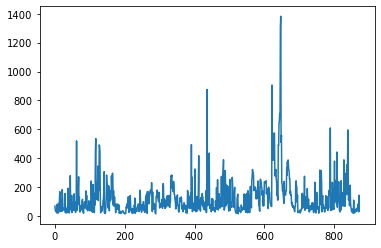

In [67]:
DV_part1['TDV'].plot()

In [68]:
DV_part1.columns

Index(['index', 'ID', 'year', 'Leg', 'Day of Week', 'month', 'matched_seg_id',
       'Lat', 'Long', 'TDV'],
      dtype='object')

In [69]:
DV_part1['year'].unique()

array([2019., 2016., 2017., 2018.])

In [70]:
# it seems still 1992--456= 1536 sites weekday saily volume still need to be estimated
# use Maximum Weekday AMI_PMI= 5.57710+7.58428e-05* population Density -4.76462* Strava Recreational Ratio

In [71]:
# Now find the short term sites in the weekday where Max_AMI_PMI was not able to calculate due to lack of data
common = weekday_hr_data.merge(DV_part1,on=['ID', 'year', 'Leg'])
sc_weekday=weekday_hr_data[(~weekday_hr_data.ID.isin(common.ID))]
sc_weekday.head()

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,ID,Date,Day of Week,Start Time,End Time,Count,Leg,...,Week Day Status,starttime,endtime,starttime1,endtime1,startDateTime,endDateTime,diff,Lat,Long
0,3432,3432,0,CH0,2018-05-30,Wednesday,7:00 AM,8:00 AM,4,N,...,Week Day,07:00:00,08:00:00,NaN,NaN,2018-05-30 07:00:00,2018-05-30 08:00:00,1.0,38.71844,-121.29042
1,3433,3433,1,CH0,2018-05-30,Wednesday,8:00 AM,9:00 AM,4,N,...,Week Day,08:00:00,09:00:00,NaN,NaN,2018-05-30 08:00:00,2018-05-30 09:00:00,1.0,38.71844,-121.29042
2,3438,3438,6,CH0,2018-05-30,Wednesday,7:00 AM,8:00 AM,1,E,...,Week Day,07:00:00,08:00:00,NaN,NaN,2018-05-30 07:00:00,2018-05-30 08:00:00,1.0,38.71844,-121.29042
3,3442,3442,10,CH0,2018-05-30,Wednesday,7:00 AM,8:00 AM,3,S,...,Week Day,07:00:00,08:00:00,NaN,NaN,2018-05-30 07:00:00,2018-05-30 08:00:00,1.0,38.71844,-121.29042
4,3443,3443,11,CH0,2018-05-30,Wednesday,8:00 AM,9:00 AM,4,S,...,Week Day,08:00:00,09:00:00,NaN,NaN,2018-05-30 08:00:00,2018-05-30 09:00:00,1.0,38.71844,-121.29042


In [72]:
weekday_hr_data.shape, sc_weekday.shape, DV_part1.shape

((28226, 27), (15204, 27), (873, 10))

In [73]:
weekday_hr_data['ID'].nunique(),DV_part1['ID'].nunique(),sc_weekday['ID'].nunique()

(1992, 570, 1422)

In [74]:
sc_weekday.head()

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,ID,Date,Day of Week,Start Time,End Time,Count,Leg,...,Week Day Status,starttime,endtime,starttime1,endtime1,startDateTime,endDateTime,diff,Lat,Long
0,3432,3432,0,CH0,2018-05-30,Wednesday,7:00 AM,8:00 AM,4,N,...,Week Day,07:00:00,08:00:00,NaN,NaN,2018-05-30 07:00:00,2018-05-30 08:00:00,1.0,38.71844,-121.29042
1,3433,3433,1,CH0,2018-05-30,Wednesday,8:00 AM,9:00 AM,4,N,...,Week Day,08:00:00,09:00:00,NaN,NaN,2018-05-30 08:00:00,2018-05-30 09:00:00,1.0,38.71844,-121.29042
2,3438,3438,6,CH0,2018-05-30,Wednesday,7:00 AM,8:00 AM,1,E,...,Week Day,07:00:00,08:00:00,NaN,NaN,2018-05-30 07:00:00,2018-05-30 08:00:00,1.0,38.71844,-121.29042
3,3442,3442,10,CH0,2018-05-30,Wednesday,7:00 AM,8:00 AM,3,S,...,Week Day,07:00:00,08:00:00,NaN,NaN,2018-05-30 07:00:00,2018-05-30 08:00:00,1.0,38.71844,-121.29042
4,3443,3443,11,CH0,2018-05-30,Wednesday,8:00 AM,9:00 AM,4,S,...,Week Day,08:00:00,09:00:00,NaN,NaN,2018-05-30 08:00:00,2018-05-30 09:00:00,1.0,38.71844,-121.29042


In [75]:
# read Strava recreation ratio data for corresponding short term sites
sc_stv=pd.read_csv('C:/UC Berkeley Project Backup/Bike_ped Exposure Model Project/Processed Data/sc_stv_2016_2019.csv')
sc_stv.head(8)

,Unnamed: 0,ID,Leg,year,Lat,Long,edgeUID,osmId,stv_total,stv_com_total,stv_rec_total,stv_com_ratio,stv_rec_ratio
0,0,CH33,N,2016.0,38.69575,-121.26919,310797458.0,10507917.0,60.0,15.0,45.0,NaN,0.750000
1,1,CH34,N,2016.0,38.70045,-121.26244,310798228.0,530730915.0,955.0,320.0,635.0,NaN,0.664921
2,2,CH35,N,2016.0,38.66973,-121.28464,310670023.0,965928012.0,170.0,25.0,145.0,NaN,0.852941
3,3,CH36,N,2016.0,38.66382,-121.28461,310669935.0,10500789.0,30.0,15.0,15.0,NaN,0.500000
4,4,CH37,N,2016.0,38.70046,-121.25426,310798370.0,530730915.0,980.0,295.0,685.0,NaN,0.698980
5,5,CH38,N,2016.0,38.70379,-121.27187,310797633.0,493808104.0,340.0,100.0,240.0,NaN,0.705882
6,6,CH39,N,2016.0,38.68536,-121.27166,310795653.0,978662300.0,25.0,5.0,20.0,NaN,0.800000
7,7,CH40,N,2016.0,38.70581,-121.25678,310798646.0,10500385.0,100.0,10.0,90.0,NaN,0.900000


In [76]:
# Calculate the populationden
count_sites=sc_stv
# Use Dr. Frank Code to get population density for each location of the counter within buffer
count_sites['geometry'] = gpd.points_from_xy(count_sites.Long, count_sites.Lat)
count_sites = gpd.GeoDataFrame(count_sites, geometry='geometry', crs='EPSG:4326')
# project the data for geographic analysis
count_sites = count_sites.to_crs(3310)

In [77]:
# Calculate the CBD Distance
## Try to pull whole CA state Network using polygon
# ca_poly=gpd.read_file('H:/Desktop/AT Census/OSM Bike Network/ca-state-boundary/CA_State_TIGER2016.shp',encoding='utf-8')
# ca_poly2=gpd.GeoDataFrame(ca_poly, geometry='geometry', crs='EPSG:3857')
# one_mile=1609.34
# ca_poly2['geometry'] = ca_poly2['geometry'].buffer(one_mile)
# ca_poly3=ca_poly2.to_crs("epsg:4326")
# polygon=ca_poly3.loc[0,'geometry']
# polygon

In [78]:
# Calculate the CBD distance
#https://wiki.openstreetmap.org/wiki/Tag:amenity%3Dtownhall
# Import University
# tags = {'office': 'government'}
# city_hall = ox.geometries_from_polygon(polygon, tags)
# city_proj = city_hall.to_crs(epsg=3310)

In [79]:
# Consider the rows that have city hall
# city_proj1 = city_proj[city_proj['name'].str.contains('City Hall', regex=False, case=False, na=False)]
# city_proj2 = city_proj[city_proj['name'].str.contains('Town Hall', regex=False, case=False, na=False)]
# city_proj3 = city_proj[city_proj['name'].str.contains('Civic Center', regex=False, case=False, na=False)]
# city_proj4 = city_proj[city_proj['name'].str.contains('Administration Building', regex=False, case=False, na=False)]
# city_proj5=pd.concat([city_proj1,city_proj2,city_proj3,city_proj4]).reset_index()
# city_proj5.head(2)

In [80]:
# Distance to CBD
# count_sites['CBD Distance'] = count_sites.geometry.apply(min_distance_ppoly, args=(city_proj5,))*0.000621371
# count_sites=count_sites.reset_index()
# count_sites.head(2)

In [81]:
# count_sites['CBD Distance'].isnull().sum()

In [82]:
#read Block group
block_groups_CA = gpd.read_file('C:/UC Berkeley Project Backup/Bike_ped Exposure Model Project/Block_Gp/nhgis0101_shape/nhgis0101_shape/nhgis0101_shapefile_tl2019_060_blck_grp_2019/CA_blck_grp_2019.shp')
block_groups_Ne=  gpd.read_file('C:/UC Berkeley Project Backup/Bike_ped Exposure Model Project/Block_Gp/nhgis0101_shape/nhgis0101_shape/nhgis0101_shapefile_tl2019_320_blck_grp_2019/NV_blck_grp_2019.shp')
block_groups=pd.concat([block_groups_CA,block_groups_Ne],axis=0).set_index('GEOID')
block_groups['aland_sqmi'] = block_groups['ALAND'] / (1609.*1609.)
block_groups.head(2)

,GISJOIN,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,Shape_Leng,Shape_Area,geometry,aland_sqmi
GEOID,,,,,,,,,,,,,,,,
060014001001,G06000104001001,06,001,400100,1,Block Group 1,G5030,S,6894339.0,0.0,+37.8676275,-122.2319460,14302.721555,6.894335e+06,"POLYGON ((-2255602.272 353149.335, -2255597.39...",2.663058
060014002001,G06000104002001,06,001,400200,1,Block Group 1,G5030,S,288069.0,0.0,+37.8497451,-122.2488478,2971.010308,2.880696e+05,"POLYGON ((-2258184.246 353217.527, -2258186.81...",0.111272


In [83]:
bg_pop = pd.read_csv('C:/UC Berkeley Project Backup/Bike_ped Exposure Model Project/Block_Gp/pop/nhgis0102_csv/nhgis0102_ds244_20195_blck_grp.csv')
bg_pop['geoid'] = bg_pop['GEOID'].str[7:]
bg_pop = bg_pop.set_index('geoid')
bg_pop = bg_pop.rename(columns={'ALUBE001': 'pop'})
bg_pop.head(2)

,GISJOIN,YEAR,STUSAB,REGIONA,DIVISIONA,STATE,STATEA,COUNTY,COUNTYA,COUSUBA,...,SDUNIA,PCI,PUMAA,GEOID,BTTRA,BTBGA,NAME_E,pop,NAME_M,ALUBM001
geoid,,,,,,,,,,,,,,,,,,,,,
060014001001,G06000104001001,2015-2019,CA,NaN,NaN,California,6,Alameda County,1,NaN,...,NaN,NaN,NaN,15000US060014001001,NaN,NaN,"Block Group 1, Census Tract 4001, Alameda Coun...",3120,"Block Group 1, Census Tract 4001, Alameda Coun...",208
060014002001,G06000104002001,2015-2019,CA,NaN,NaN,California,6,Alameda County,1,NaN,...,NaN,NaN,NaN,15000US060014002001,NaN,NaN,"Block Group 1, Census Tract 4002, Alameda Coun...",990,"Block Group 1, Census Tract 4002, Alameda Coun...",138


In [84]:
block_groups = block_groups.join(bg_pop[['pop']])
# calculate area-weightd average population density - make this a function if needed
count_sites = count_sites.set_index(['ID', 'year'])

block_groups['popden'] = block_groups['pop']/block_groups['aland_sqmi']
block_groups = block_groups.to_crs(3310)

count_sites['buffer_geometry'] = count_sites.buffer(1609.)
count_sites = count_sites.set_geometry('buffer_geometry')

joined_geos = count_sites[['buffer_geometry']].\
    sjoin(block_groups[['geometry']]).\
    join(block_groups[['geometry']], on='index_right')

joined_geos['overlap'] = joined_geos['buffer_geometry'].intersection(joined_geos['geometry']).area

joined_geos['overlap_ratio'] = joined_geos['overlap']/(joined_geos['buffer_geometry'].area)

joined_geos = joined_geos.join(block_groups[['popden']], on='index_right')

joined_geos['weighted_popden'] = joined_geos['overlap_ratio'] * joined_geos['popden']

count_sites['popden'] = joined_geos.groupby(['ID', 'year'])['weighted_popden'].sum()

In [85]:
count_sites = count_sites.set_geometry('geometry').drop(columns='buffer_geometry')

In [86]:
count_sites=count_sites.reset_index()
count_sites.head(2)

,ID,year,Unnamed: 0,Leg,Lat,Long,edgeUID,osmId,stv_total,stv_com_total,stv_rec_total,stv_com_ratio,stv_rec_ratio,geometry,popden
0,CH33,2016.0,0,N,38.69575,-121.26919,310797458.0,10507917.0,60.0,15.0,45.0,NaN,0.750000,POINT (-110266.628 76259.750),5747.314076
1,CH34,2016.0,1,N,38.70045,-121.26244,310798228.0,530730915.0,955.0,320.0,635.0,NaN,0.664921,POINT (-109673.279 76774.311),5526.284064


In [87]:
count_sites.to_csv('C:/UC Berkeley Project Backup/Bike_ped Exposure Model Project/Estimated_Outcomes/Sc_Stv_pop_CBD.csv')

In [88]:
# separate 2019 and 2018 data as it has strava 
#count_sites1=count_sites[(count_sites['year']==2019)|(count_sites['year']==2018)]
count_sites1=count_sites
count_sites1['stv_rec_ratio'].fillna(0, inplace=True)
count_sites1['popden'].fillna(1, inplace=True)
count_sites1.head()

,ID,year,Unnamed: 0,Leg,Lat,Long,edgeUID,osmId,stv_total,stv_com_total,stv_rec_total,stv_com_ratio,stv_rec_ratio,geometry,popden
0,CH33,2016.0,0,N,38.69575,-121.26919,310797458.0,10507917.0,60.0,15.0,45.0,NaN,0.750000,POINT (-110266.628 76259.750),5747.314076
1,CH34,2016.0,1,N,38.70045,-121.26244,310798228.0,530730915.0,955.0,320.0,635.0,NaN,0.664921,POINT (-109673.279 76774.311),5526.284064
2,CH35,2016.0,2,N,38.66973,-121.28464,310670023.0,965928012.0,170.0,25.0,145.0,NaN,0.852941,POINT (-111648.027 73385.817),6284.000212
3,CH36,2016.0,3,N,38.66382,-121.28461,310669935.0,10500789.0,30.0,15.0,15.0,NaN,0.500000,POINT (-111654.322 72728.910),5461.086301
4,CH37,2016.0,4,N,38.70046,-121.25426,310798370.0,530730915.0,980.0,295.0,685.0,NaN,0.698980,POINT (-108962.669 76765.993),5112.178477


In [89]:
count_sites1['stv_rec_ratio'].isnull().sum()

0

In [90]:
count_sites1['ID'].nunique()

2129

# Now estimate Weekday Max AMI_PMI 


In [91]:
a=3.77571742
b= 9.29116576e-05
c= -3.10154018e+00
count_sites1['Max_AMI_PMI']=a+b*count_sites1['popden']+c*np.power(count_sites1['stv_rec_ratio'],2)
count_sites1.head(3)

,ID,year,Unnamed: 0,Leg,Lat,Long,edgeUID,osmId,stv_total,stv_com_total,stv_rec_total,stv_com_ratio,stv_rec_ratio,geometry,popden,Max_AMI_PMI
0,CH33,2016.0,0,N,38.69575,-121.26919,310797458.0,10507917.0,60.0,15.0,45.0,NaN,0.750000,POINT (-110266.628 76259.750),5747.314076,2.565094
1,CH34,2016.0,1,N,38.70045,-121.26244,310798228.0,530730915.0,955.0,320.0,635.0,NaN,0.664921,POINT (-109673.279 76774.311),5526.284064,2.917919
2,CH35,2016.0,2,N,38.66973,-121.28464,310670023.0,965928012.0,170.0,25.0,145.0,NaN,0.852941,POINT (-111648.027 73385.817),6284.000212,2.103177


In [92]:
count_sites1['Max_AMI_PMI'].describe()

count    2130.000000
mean        2.295837
std         1.228000
min         0.674576
25%         1.191508
50%         2.015868
75%         3.360500
max         6.060179
Name: Max_AMI_PMI, dtype: float64

In [93]:
#count_sites2=count_sites[(count_sites['year']==2016)|(count_sites['year']==2017)]
count_sites1['popden'].fillna(1, inplace=True)

In [94]:
#count_sites1['popden'].isnull().sum(),count_sites1['CBD Distance'].isnull().sum()

In [95]:
count_sites1['ID'].nunique()

2129

In [96]:
# Strava is missing for 2016 and 2017, therefore,now use Maximum Weekday AMI_PMI= -0.32406+0.03444*√("population Density" ) +𝟎.𝟎𝟒𝟐𝟖𝟑∗𝐥𝐧(𝐃𝐢𝐬𝐭𝐚𝐧𝐜𝐞 𝐭𝐨 𝐂𝐁𝐃 𝐢𝐧 𝐦𝐢𝐥𝐞) to 
#calculate max AMI_PMI for 2016 and 2017 data 
#count_sites2=count_sites[(count_sites['year']==2016)|(count_sites['year']==2017)]
# a=-0.32406
# b=0.03444
# c=0.04283
# count_sites2['Max_AMI_PMI']=a+b*np.sqrt(count_sites2['popden'])+c*np.log(count_sites2['CBD Distance'])
# count_sites2.head()

In [97]:
# count_sites1['Max_AMI_PMI'].isnull().sum(), count_sites2['Max_AMI_PMI'].isnull().sum()

In [98]:
sc_weekday.head()

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,ID,Date,Day of Week,Start Time,End Time,Count,Leg,...,Week Day Status,starttime,endtime,starttime1,endtime1,startDateTime,endDateTime,diff,Lat,Long
0,3432,3432,0,CH0,2018-05-30,Wednesday,7:00 AM,8:00 AM,4,N,...,Week Day,07:00:00,08:00:00,NaN,NaN,2018-05-30 07:00:00,2018-05-30 08:00:00,1.0,38.71844,-121.29042
1,3433,3433,1,CH0,2018-05-30,Wednesday,8:00 AM,9:00 AM,4,N,...,Week Day,08:00:00,09:00:00,NaN,NaN,2018-05-30 08:00:00,2018-05-30 09:00:00,1.0,38.71844,-121.29042
2,3438,3438,6,CH0,2018-05-30,Wednesday,7:00 AM,8:00 AM,1,E,...,Week Day,07:00:00,08:00:00,NaN,NaN,2018-05-30 07:00:00,2018-05-30 08:00:00,1.0,38.71844,-121.29042
3,3442,3442,10,CH0,2018-05-30,Wednesday,7:00 AM,8:00 AM,3,S,...,Week Day,07:00:00,08:00:00,NaN,NaN,2018-05-30 07:00:00,2018-05-30 08:00:00,1.0,38.71844,-121.29042
4,3443,3443,11,CH0,2018-05-30,Wednesday,8:00 AM,9:00 AM,4,S,...,Week Day,08:00:00,09:00:00,NaN,NaN,2018-05-30 08:00:00,2018-05-30 09:00:00,1.0,38.71844,-121.29042


In [99]:
# Now combine count_sites1 and count sites 2 data
#count_sites3=pd.concat([count_sites1,count_sites2],axis=0)
count_sites4=pd.merge(sc_weekday,count_sites1,on=['ID','year'], how='inner')
count_sites4.head()

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0_x,ID,Date,Day of Week,Start Time,End Time,Count,Leg_x,...,edgeUID,osmId,stv_total,stv_com_total,stv_rec_total,stv_com_ratio,stv_rec_ratio,geometry,popden,Max_AMI_PMI
0,3432,3432,0,CH0,2018-05-30,Wednesday,7:00 AM,8:00 AM,4,N,...,310765851.0,617513986.0,25.0,0.0,25.0,0.0,1.0,POINT (-112076.632 78806.505),5039.838905,1.142437
1,3433,3433,1,CH0,2018-05-30,Wednesday,8:00 AM,9:00 AM,4,N,...,310765851.0,617513986.0,25.0,0.0,25.0,0.0,1.0,POINT (-112076.632 78806.505),5039.838905,1.142437
2,3438,3438,6,CH0,2018-05-30,Wednesday,7:00 AM,8:00 AM,1,E,...,310765851.0,617513986.0,25.0,0.0,25.0,0.0,1.0,POINT (-112076.632 78806.505),5039.838905,1.142437
3,3442,3442,10,CH0,2018-05-30,Wednesday,7:00 AM,8:00 AM,3,S,...,310765851.0,617513986.0,25.0,0.0,25.0,0.0,1.0,POINT (-112076.632 78806.505),5039.838905,1.142437
4,3443,3443,11,CH0,2018-05-30,Wednesday,8:00 AM,9:00 AM,4,S,...,310765851.0,617513986.0,25.0,0.0,25.0,0.0,1.0,POINT (-112076.632 78806.505),5039.838905,1.142437


In [100]:
sc_weekday['ID'].nunique(), count_sites4['ID'].nunique()

(1422, 1422)

In [101]:
count_sites4=count_sites4.rename(columns={"Leg_x":'Leg'})
count_sites4=count_sites4.rename(columns={"Lat_x":'Lat'})
count_sites4=count_sites4.rename(columns={"Long_x":'Long'})

In [102]:
count_sites1['Max_AMI_PMI'].isnull().sum(), count_sites4['Max_AMI_PMI'].isnull().sum()

(0, 0)

In [103]:
sc_weekday.shape,count_sites1.shape

((15204, 27), (2130, 16))

In [104]:
sc_weekday['ID'].nunique(),count_sites4['ID'].nunique()

(1422, 1422)

In [105]:
# split by MAX AMI_PMI Value
m_g1=count_sites4.loc[count_sites4['Max_AMI_PMI']<=1]
m_g2=count_sites4[(count_sites4.Max_AMI_PMI>1) &(count_sites4.Max_AMI_PMI<=2.50)]
m_g3=count_sites4.loc[count_sites4['Max_AMI_PMI']>2.50]
m_g3.head(2)

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0_x,ID,Date,Day of Week,Start Time,End Time,Count,Leg,...,edgeUID,osmId,stv_total,stv_com_total,stv_rec_total,stv_com_ratio,stv_rec_ratio,geometry,popden,Max_AMI_PMI
19,3451,3451,19,CH1,2018-05-30,Wednesday,7:00 AM,8:00 AM,1,N,...,310761780.0,502915570.0,100.0,35.0,65.0,0.35,0.65,POINT (-112091.072 77490.506),5537.456647,2.979811
20,3452,3452,20,CH1,2018-05-30,Wednesday,8:00 AM,9:00 AM,4,N,...,310761780.0,502915570.0,100.0,35.0,65.0,0.35,0.65,POINT (-112091.072 77490.506),5537.456647,2.979811


In [106]:
m_g1.shape,m_g2.shape,m_g3.shape,count_sites4.shape

((1213, 41), (7744, 41), (6140, 41), (15097, 41))

In [107]:
m_g3.columns

Index(['Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0_x', 'ID', 'Date',
       'Day of Week', 'Start Time', 'End Time', 'Count', 'Leg',
       'matched_seg_id', 'date', 'month', 'year', 'day', 'dayofweek',
       'weekday_Status', 'Week Day Status', 'starttime', 'endtime',
       'starttime1', 'endtime1', 'startDateTime', 'endDateTime', 'diff', 'Lat',
       'Long', 'Unnamed: 0_y', 'Leg_y', 'Lat_y', 'Long_y', 'edgeUID', 'osmId',
       'stv_total', 'stv_com_total', 'stv_rec_total', 'stv_com_ratio',
       'stv_rec_ratio', 'geometry', 'popden', 'Max_AMI_PMI'],
      dtype='object')

In [108]:
# Calculate daily Volume for group 1
mg1_DV=pd.merge(m_g1,HOD_weekday_g1, on=['starttime'], how='inner')
mg1_DV1=pd.DataFrame({'agge_count' : mg1_DV.groupby(['ID','year','month','day','Leg','Day of Week','matched_seg_id','Lat','Long'])['Count'].sum()}).reset_index()
mg1_DV1f=pd.DataFrame({'agge_factor' : mg1_DV.groupby(['ID','year','month','day','Leg','Day of Week','matched_seg_id','Lat','Long'])['Average_Group_HOD_Factor'].sum()}).reset_index()
mg1_DV1r=pd.merge(mg1_DV1,mg1_DV1f, on=['ID','year','month','day','Leg','Day of Week','matched_seg_id','Lat','Long'], how='inner')
mg1_DV1r['Daily_Volume']=mg1_DV1r['agge_count']/mg1_DV1r['agge_factor']
mg1_DV1rf=pd.DataFrame({'TDV' : mg1_DV1r.groupby(['ID','year','Leg','Day of Week','month','matched_seg_id','Lat','Long'])['Daily_Volume'].mean()}).reset_index()

In [109]:
c=mg1_DV.loc[mg1_DV['Count']==0]
c1=mg1_DV1.loc[mg1_DV1['agge_count']==0]
c.shape,c1.shape

((12, 45), (2, 10))

In [110]:
mg1_DV1rf.isnull().sum()

ID                0
year              0
Leg               0
Day of Week       0
month             0
matched_seg_id    0
Lat               0
Long              0
TDV               0
dtype: int64

In [111]:
# Calculate daily Volume for group 2
mg2_DV=pd.merge(m_g2,HOD_weekday_g2, on=['starttime'], how='inner')
mg2_DV2=pd.DataFrame({'agge_count' : mg2_DV.groupby(['ID','year','month','day','Leg','Day of Week','matched_seg_id','Lat','Long'])['Count'].sum()}).reset_index()
mg2_DV2f=pd.DataFrame({'agge_factor' : mg2_DV.groupby(['ID','year','month','day','Leg','Day of Week','matched_seg_id','Lat','Long'])['Average_Group_HOD_Factor'].sum()}).reset_index()
mg2_DV2r=pd.merge(mg2_DV2,mg2_DV2f, on=['ID','year','month','day','Leg','Day of Week','matched_seg_id','Lat','Long'], how='inner')
mg2_DV2r['Daily_Volume']=mg2_DV2r['agge_count']/mg2_DV2r['agge_factor']
mg2_DV2rf=pd.DataFrame({'TDV' : mg2_DV2r.groupby(['ID','year','Leg','Day of Week','month','matched_seg_id','Lat','Long'])['Daily_Volume'].mean()}).reset_index()

In [112]:
c=mg2_DV.loc[mg2_DV['Count']==0]
c1=mg2_DV2.loc[mg2_DV2['agge_count']==0]
c.shape,c1.shape

((238, 45), (49, 10))

In [113]:
mg2_DV2.shape,mg2_DV2f.shape,mg2_DV2r.shape

((1996, 10), (1996, 10), (1996, 12))

In [114]:
c=mg2_DV2r.loc[mg2_DV2r['agge_count']==0]
c.shape

(49, 12)

In [115]:
mg2_DV2r.isnull().sum()

ID                0
year              0
month             0
day               0
Leg               0
Day of Week       0
matched_seg_id    0
Lat               0
Long              0
agge_count        0
agge_factor       0
Daily_Volume      0
dtype: int64

In [116]:
# Calculate daily Volume for group 3
mg3_DV=pd.merge(m_g3,HOD_weekday_g3, on=['starttime'], how='inner')
mg3_DV3=pd.DataFrame({'agge_count' : mg3_DV.groupby(['ID','year','month','day','Leg','Day of Week','matched_seg_id','Lat','Long'])['Count'].sum()}).reset_index()
mg3_DV3f=pd.DataFrame({'agge_factor' : mg3_DV.groupby(['ID','year','month','day','Leg','Day of Week','matched_seg_id','Lat','Long'])['Average_Group_HOD_Factor'].sum()}).reset_index()
mg3_DV3r=pd.merge(mg3_DV3,mg3_DV3f, on=['ID','year','month','day','Leg','Day of Week','matched_seg_id','Lat','Long'], how='inner')
mg3_DV3r['Daily_Volume']=mg3_DV3r['agge_count']/mg3_DV3r['agge_factor']
mg3_DV3rf=pd.DataFrame({'TDV' : mg3_DV3r.groupby(['ID','year','Leg','Day of Week','month','matched_seg_id','Lat','Long'])['Daily_Volume'].mean()}).reset_index()

In [117]:
c=mg3_DV.loc[mg3_DV['Count']==0]
c1=mg3_DV3.loc[mg3_DV3['agge_count']==0]
c.shape,c1.shape

((187, 45), (44, 10))

In [118]:
mg3_DV3rf.isnull().sum()

ID                0
year              0
Leg               0
Day of Week       0
month             0
matched_seg_id    0
Lat               0
Long              0
TDV               0
dtype: int64

In [119]:
# Apply factor to obtain daily Volume
# mg1_DV=pd.merge(m_g1,HOD_weekday_g1, on=['starttime'], how='inner')
# mg1_DV['Daily_Volume']=mg1_DV['Count']/mg1_DV['Average_Group_HOD_Factor']
# mg1_DV1=pd.DataFrame({'TDV' : mg1_DV.groupby(['ID','year','Leg','Day of Week','month','matched_seg_id','Lat','Long'])['Daily_Volume'].mean()}).reset_index()
# mg2_DV=pd.merge(m_g2,HOD_weekday_g2, on=['starttime'], how='inner')
# mg2_DV['Daily_Volume']=mg2_DV['Count']/mg2_DV['Average_Group_HOD_Factor']
# mg2_DV2=pd.DataFrame({'TDV' : mg2_DV.groupby(['ID','year','Leg','Day of Week','month','matched_seg_id','Lat','Long'])['Daily_Volume'].mean()}).reset_index()
# mg3_DV=pd.merge(m_g3,HOD_weekday_g3, on=['starttime'], how='inner')
# mg3_DV['Daily_Volume']=mg3_DV['Count']/mg3_DV['Average_Group_HOD_Factor']
# mg3_DV3=pd.DataFrame({'TDV' : mg3_DV.groupby(['ID','year','Leg','Day of Week','month','matched_seg_id','Lat','Long'])['Daily_Volume'].mean()}).reset_index()
# mg3_DV3.head()

In [120]:
mg1_DV1rf['ID'].nunique(),mg1_DV1rf['ID'].nunique(),mg2_DV2rf['ID'].nunique(),mg2_DV2rf['ID'].nunique(),mg3_DV3rf['ID'].nunique(),mg3_DV3rf['ID'].nunique()

(158, 158, 604, 604, 645, 645)

In [121]:
mg1_DV1rf.shape, mg1_DV1r.shape

((350, 9), (350, 12))

In [122]:
# combine these three group of estimated daily volume together
DV_part2=pd.concat([mg1_DV1rf,mg2_DV2rf,mg3_DV3rf],axis=0).reset_index()
DV_part2.shape

(4457, 10)

In [123]:
DV_part2.isnull().sum()

index             0
ID                0
year              0
Leg               0
Day of Week       0
month             0
matched_seg_id    0
Lat               0
Long              0
TDV               0
dtype: int64

In [124]:
DV_part2.head()

,index,ID,year,Leg,Day of Week,month,matched_seg_id,Lat,Long,TDV
0,0,AC201639,2016.0,E,Wednesday,9.0,154438,37.68136,-121.70956,25.966442
1,1,AC201639,2016.0,N,Wednesday,9.0,bearing calculation not match with TMS count,37.68136,-121.70956,43.277403
2,2,AC201639,2016.0,S,Wednesday,9.0,154433,37.68136,-121.70956,37.507083
3,3,AC201639,2016.0,W,Wednesday,9.0,154430,37.68136,-121.70956,37.507083
4,4,AC20179,2017.0,E,Wednesday,11.0,154395,37.66512,-121.73288,34.508641


<AxesSubplot:>

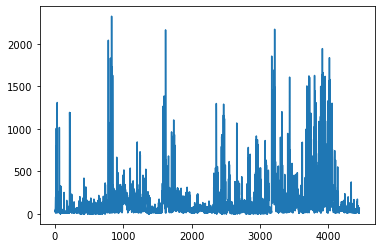

In [125]:
DV_part2['TDV'].plot()

In [126]:
# Combine all Estimated weekday Daily Volume
Weekday_DV=pd.concat([DV_part1,DV_part2],axis=0)
Weekday_DV.shape

(5330, 10)

In [127]:
weekday_hr_data['ID'].nunique(),Weekday_DV['ID'].nunique(),DV_part1['ID'].nunique(),DV_part2['ID'].nunique()

(1992, 1977, 570, 1407)

# Now Estimate weekend Daily Volume

In [128]:
weekend_hr_data.head()

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,ID,Date,Day of Week,Start Time,End Time,Count,Leg,...,Week Day Status,starttime,endtime,starttime1,endtime1,startDateTime,endDateTime,diff,Lat,Long
1086,4676,4676,446,Kern7,2016-12-17,Saturday,7:00 AM,8:00 AM,4,N,...,Weekend,07:00:00,08:00:00,NaN,NaN,2016-12-17 07:00:00,2016-12-17 08:00:00,1.0,35.365131,-118.93197
1087,4677,4677,447,Kern7,2016-12-17,Saturday,8:00 AM,9:00 AM,1,N,...,Weekend,08:00:00,09:00:00,NaN,NaN,2016-12-17 08:00:00,2016-12-17 09:00:00,1.0,35.365131,-118.93197
1088,4678,4678,448,Kern7,2016-12-17,Saturday,9:00 AM,10:00 AM,2,N,...,Weekend,09:00:00,10:00:00,NaN,NaN,2016-12-17 09:00:00,2016-12-17 10:00:00,1.0,35.365131,-118.93197
1089,4679,4679,449,Kern7,2016-12-17,Saturday,10:00 AM,11:00 AM,4,N,...,Weekend,10:00:00,11:00:00,NaN,NaN,2016-12-17 10:00:00,2016-12-17 11:00:00,1.0,35.365131,-118.93197
1095,4680,4680,450,Kern7,2016-12-17,Saturday,12:00 PM,1:00 PM,1,N,...,Weekend,12:00:00,13:00:00,NaN,NaN,2016-12-17 12:00:00,2016-12-17 13:00:00,1.0,35.365131,-118.93197


In [129]:
weekend_hr_data['Count'].min()

0

In [130]:
count_sites=count_sites.drop(['Leg','Lat','Long'],axis=1)
count_sites.head(2)

,ID,year,Unnamed: 0,edgeUID,osmId,stv_total,stv_com_total,stv_rec_total,stv_com_ratio,stv_rec_ratio,geometry,popden,Max_AMI_PMI
0,CH33,2016.0,0,310797458.0,10507917.0,60.0,15.0,45.0,NaN,0.750000,POINT (-110266.628 76259.750),5747.314076,2.565094
1,CH34,2016.0,1,310798228.0,530730915.0,955.0,320.0,635.0,NaN,0.664921,POINT (-109673.279 76774.311),5526.284064,2.917919


In [131]:
weekend_hr_data.shape, count_sites.shape

((2468, 27), (2130, 13))

In [132]:
weekend_hr_data1=pd.merge(weekend_hr_data,count_sites,on=['ID','year'], how='inner')
weekend_hr_data1.shape

(2462, 38)

In [133]:
weekend_hr_data1.head()

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0_x,ID,Date,Day of Week,Start Time,End Time,Count,Leg,...,edgeUID,osmId,stv_total,stv_com_total,stv_rec_total,stv_com_ratio,stv_rec_ratio,geometry,popden,Max_AMI_PMI
0,4676,4676,446,Kern7,2016-12-17,Saturday,7:00 AM,8:00 AM,4,N,...,308518631.0,10411960.0,10.0,0.0,10.0,NaN,1.0,POINT (96960.699 -294095.797),5554.147258,1.190222
1,4677,4677,447,Kern7,2016-12-17,Saturday,8:00 AM,9:00 AM,1,N,...,308518631.0,10411960.0,10.0,0.0,10.0,NaN,1.0,POINT (96960.699 -294095.797),5554.147258,1.190222
2,4678,4678,448,Kern7,2016-12-17,Saturday,9:00 AM,10:00 AM,2,N,...,308518631.0,10411960.0,10.0,0.0,10.0,NaN,1.0,POINT (96960.699 -294095.797),5554.147258,1.190222
3,4679,4679,449,Kern7,2016-12-17,Saturday,10:00 AM,11:00 AM,4,N,...,308518631.0,10411960.0,10.0,0.0,10.0,NaN,1.0,POINT (96960.699 -294095.797),5554.147258,1.190222
4,4680,4680,450,Kern7,2016-12-17,Saturday,12:00 PM,1:00 PM,1,N,...,308518631.0,10411960.0,10.0,0.0,10.0,NaN,1.0,POINT (96960.699 -294095.797),5554.147258,1.190222


In [134]:
weekend_hr_data1.columns

Index(['Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0_x', 'ID', 'Date',
       'Day of Week', 'Start Time', 'End Time', 'Count', 'Leg',
       'matched_seg_id', 'date', 'month', 'year', 'day', 'dayofweek',
       'weekday_Status', 'Week Day Status', 'starttime', 'endtime',
       'starttime1', 'endtime1', 'startDateTime', 'endDateTime', 'diff', 'Lat',
       'Long', 'Unnamed: 0_y', 'edgeUID', 'osmId', 'stv_total',
       'stv_com_total', 'stv_rec_total', 'stv_com_ratio', 'stv_rec_ratio',
       'geometry', 'popden', 'Max_AMI_PMI'],
      dtype='object')

In [135]:
weekend_hr_data1['starttime'].isnull().sum()

0

In [136]:
weekend_hr_data['ID'].nunique(),weekend_hr_data1['ID'].nunique()

(148, 147)

In [137]:
# weekend_hr_data1=weekend_hr_data1.rename(columns={"Leg_x":'Leg'})
# weekend_hr_data1=weekend_hr_data1.rename(columns={"Lat_x":'Lat'})
# weekend_hr_data11=weekend_hr_data1.rename(columns={"Long_x":'Long'})

In [138]:
# Split the weekend data by strava recreational threshold to apply factor
w_g1=weekend_hr_data1.loc[weekend_hr_data1['stv_rec_ratio']<=0.75]
w_g2=weekend_hr_data1.loc[weekend_hr_data1['stv_rec_ratio']>0.75]
w_g2.tail(2)

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0_x,ID,Date,Day of Week,Start Time,End Time,Count,Leg,...,edgeUID,osmId,stv_total,stv_com_total,stv_rec_total,stv_com_ratio,stv_rec_ratio,geometry,popden,Max_AMI_PMI
2460,19310,19310,558,SCC73,2018-06-02,Saturday,1/1/1900 11:00,1/1/1900 12:00,38,W,...,308903477.0,10551966.0,4075.0,355.0,3720.0,0.087117,0.912883,POINT (-184099.677 -106086.871),695.462189,1.255646
2461,19311,19311,559,SCC73,2018-06-02,Saturday,1/1/1900 12:00,1/1/1900 13:00,24,W,...,308903477.0,10551966.0,4075.0,355.0,3720.0,0.087117,0.912883,POINT (-184099.677 -106086.871),695.462189,1.255646


In [139]:
weekend_hr_data1['stv_rec_ratio'].isnull().sum()

0

In [140]:
w_g1.shape,w_g2.shape, weekend_hr_data1.shape

((325, 38), (2137, 38), (2462, 38))

In [141]:
# Split the factor by criteria
HOD_weekend=HOD.loc[HOD['day_of_status']=='weekend']
HOD_weekend_g1=HOD_weekend.loc[HOD_weekend['Criteria']=='Average_stv_rec_ratio<=0.75']
HOD_weekend_g2=HOD_weekend.loc[HOD_weekend['Criteria']=='Average_stv_rec_ratio>0.75']
HOD_weekend_g1.head()

,Unnamed: 0,starttime,Average_Group_HOD_Factor,Criteria,day_of_status
72,0,00:00:00,0.012068,Average_stv_rec_ratio<=0.75,weekend
73,1,01:00:00,0.007182,Average_stv_rec_ratio<=0.75,weekend
74,2,02:00:00,0.005637,Average_stv_rec_ratio<=0.75,weekend
75,3,03:00:00,0.003976,Average_stv_rec_ratio<=0.75,weekend
76,4,04:00:00,0.003748,Average_stv_rec_ratio<=0.75,weekend


In [142]:
weekend_hr_data1.columns

Index(['Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0_x', 'ID', 'Date',
       'Day of Week', 'Start Time', 'End Time', 'Count', 'Leg',
       'matched_seg_id', 'date', 'month', 'year', 'day', 'dayofweek',
       'weekday_Status', 'Week Day Status', 'starttime', 'endtime',
       'starttime1', 'endtime1', 'startDateTime', 'endDateTime', 'diff', 'Lat',
       'Long', 'Unnamed: 0_y', 'edgeUID', 'osmId', 'stv_total',
       'stv_com_total', 'stv_rec_total', 'stv_com_ratio', 'stv_rec_ratio',
       'geometry', 'popden', 'Max_AMI_PMI'],
      dtype='object')

In [143]:
# Calculate daily Volume for group 1
wg1_DV=pd.merge(w_g1,HOD_weekend_g1, on=['starttime'], how='inner')
wg1_DV1=pd.DataFrame({'agge_count' : wg1_DV.groupby(['ID','year','month','day','Leg','Day of Week','matched_seg_id','Lat','Long'])['Count'].sum()}).reset_index()
wg1_DV1f=pd.DataFrame({'agge_factor' : wg1_DV.groupby(['ID','year','month','day','Leg','Day of Week','matched_seg_id','Lat','Long'])['Average_Group_HOD_Factor'].sum()}).reset_index()
wg1_DV1r=pd.merge(wg1_DV1,wg1_DV1f, on=['ID','year','month','day','Leg','Day of Week','matched_seg_id','Lat','Long'], how='inner')
wg1_DV1r['Daily_Volume']=wg1_DV1r['agge_count']/wg1_DV1r['agge_factor']
wg1_DV1rf=pd.DataFrame({'TDV' : wg1_DV1r.groupby(['ID','year','Leg','Day of Week','month','matched_seg_id','Lat','Long'])['Daily_Volume'].mean()}).reset_index()

In [144]:
c=wg1_DV.loc[wg1_DV['Count']==0]
c1=wg1_DV1.loc[wg1_DV1['agge_count']==0]
c.shape,c1.shape

((4, 42), (1, 10))

In [145]:
# Calculate daily Volume for group 1
wg2_DV=pd.merge(w_g2,HOD_weekend_g2, on=['starttime'], how='inner')
wg2_DV2=pd.DataFrame({'agge_count' : wg2_DV.groupby(['ID','year','month','day','Leg','Day of Week','matched_seg_id','Lat','Long'])['Count'].sum()}).reset_index()
wg2_DV2f=pd.DataFrame({'agge_factor' : wg2_DV.groupby(['ID','year','month','day','Leg','Day of Week','matched_seg_id','Lat','Long'])['Average_Group_HOD_Factor'].sum()}).reset_index()
wg2_DV2r=pd.merge(wg2_DV2,wg2_DV2f, on=['ID','year','month','day','Leg','Day of Week','matched_seg_id','Lat','Long'], how='inner')
wg2_DV2r['Daily_Volume']=wg2_DV2r['agge_count']/wg2_DV2r['agge_factor']
wg2_DV2rf=pd.DataFrame({'TDV' : wg2_DV2r.groupby(['ID','year','Leg','Day of Week','month','matched_seg_id','Lat','Long'])['Daily_Volume'].mean()}).reset_index()

In [146]:
c=wg2_DV.loc[wg2_DV['Count']==0]
c1=wg2_DV2.loc[wg2_DV2['agge_count']==0]
c.shape,c1.shape

((30, 42), (6, 10))

In [147]:
# Apply factor to obtain daily Volume
# wg1_DV=pd.merge(w_g1,HOD_weekend_g1, on=['starttime'], how='inner')
# wg1_DV['Daily_Volume']=wg1_DV['Count']/wg1_DV['Average_Group_HOD_Factor']
# wg1_DV1=pd.DataFrame({'TDV' : wg1_DV.groupby(['ID','year','Leg','Day of Week','month','matched_seg_id','Lat','Long'])['Daily_Volume'].mean()}).reset_index()
# wg2_DV=pd.merge(w_g2,HOD_weekend_g2, on=['starttime'], how='inner')
# wg2_DV['Daily_Volume']=wg2_DV['Count']/wg2_DV['Average_Group_HOD_Factor']
# wg2_DV2=pd.DataFrame({'TDV' : wg2_DV.groupby(['ID','year','Leg','Day of Week','month','matched_seg_id','Lat','Long'])['Daily_Volume'].mean()}).reset_index()

In [148]:
wg1_DV1rf['ID'].nunique(),wg1_DV1rf['ID'].nunique(),wg2_DV2rf['ID'].nunique(),wg2_DV2rf['ID'].nunique()

(25, 25, 122, 122)

In [149]:
# combine these three group of estimated daily volume together
Weekend_DV_part1=pd.concat([wg1_DV1rf,wg2_DV2rf],axis=0).reset_index()
Weekend_DV_part1.shape

(499, 10)

In [150]:
# Now find the short term sites in the weekend where strava recreation data was not available to calculate due to lack of data
common = weekend_hr_data1.merge(Weekend_DV_part1,on=['ID', 'year', 'Leg'])
weekend_hr_data2=weekend_hr_data1[(~weekend_hr_data1.ID.isin(common.ID))]
weekend_hr_data2=weekend_hr_data2.drop(['stv_rec_ratio'],axis=1)
weekend_hr_data2.head()

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0_x,ID,Date,Day of Week,Start Time,End Time,Count,Leg,...,Unnamed: 0_y,edgeUID,osmId,stv_total,stv_com_total,stv_rec_total,stv_com_ratio,geometry,popden,Max_AMI_PMI


In [151]:
# Now estimate Strava recreation Ratio using the formula Strava Recreational Ratio (SRR)= 0.96967-0.00303*√("population Density" ) +𝟎.𝟎𝟐𝟑𝟗𝟓∗𝐥𝐧(𝐃𝐢𝐬𝐭𝐚𝐧𝐜𝐞 𝐭𝐨 𝐂𝐁𝐃 𝐢𝐧 𝐦𝐢𝐥𝐞)
# a=0.96967
# b=-0.00303
# c=0.02395
# weekend_hr_data2['stv_rec_ratio']=a+b*np.sqrt(weekend_hr_data2['popden'])+c*np.log(weekend_hr_data2['CBD Distance'])
# weekend_hr_data2.head()

In [152]:
#weekend_hr_data2['stv_rec_ratio'].describe()

In [153]:
# Split the weekend data by strava recreational threshold to apply factor
# w_g11=weekend_hr_data2.loc[weekend_hr_data2['stv_rec_ratio']<=0.75]
# w_g22=weekend_hr_data2.loc[weekend_hr_data2['stv_rec_ratio']>0.75]
# w_g22.tail(2)

In [154]:
# Apply factor to obtain daily Volume
# wg11_DV=pd.merge(w_g11,HOD_weekend_g1, on=['starttime'], how='inner')
# wg11_DV['Daily_Volume']=wg11_DV['Count']/wg11_DV['Average_Group_HOD_Factor']
# wg11_DV11=pd.DataFrame({'TDV' : wg11_DV.groupby(['ID','year','Leg','Day of Week','month','matched_seg_id','Lat','Long'])['Daily_Volume'].mean()}).reset_index()
# wg22_DV=pd.merge(w_g22,HOD_weekend_g2, on=['starttime'], how='inner')
# wg22_DV['Daily_Volume']=wg22_DV['Count']/wg22_DV['Average_Group_HOD_Factor']
# wg22_DV22=pd.DataFrame({'TDV' : wg22_DV.groupby(['ID','year','Leg','Day of Week','month','matched_seg_id','Lat','Long'])['Daily_Volume'].mean()}).reset_index()

In [155]:
# combine these three group of estimated daily volume together
# Weekend_DV_part2=pd.concat([wg11_DV11,wg22_DV22],axis=0).reset_index()
# Weekend_DV_part2.shape

In [156]:
# combine weekend total estimated daily volume data
Weekend_DV=Weekend_DV_part1

<AxesSubplot:>

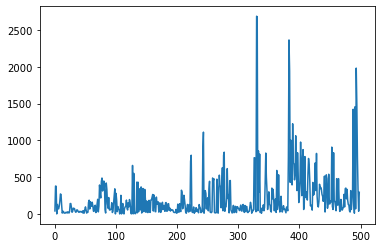

In [157]:
Weekend_DV['TDV'].plot()

In [158]:
Weekend_DV['ID'].nunique()

147

# Combine weekday and weekend Estimated Daily Volume

In [159]:
ES_DV=pd.concat([Weekday_DV, Weekend_DV],axis=0).reset_index()
ES_DV.head()

,level_0,index,ID,year,Leg,Day of Week,month,matched_seg_id,Lat,Long,TDV
0,0,0,CH17,2019.0,E,Tuesday,3.0,89834,38.67821,-121.29246,67.478012
1,1,1,CH17,2019.0,N,Tuesday,3.0,89833,38.67821,-121.29246,41.480372
2,2,2,CH17,2019.0,S,Tuesday,3.0,89698,38.67821,-121.29246,30.248764
3,3,3,CH23,2019.0,N,Tuesday,3.0,89504,38.67837,-121.28207,36.878528
4,4,4,CH25,2019.0,S,Tuesday,3.0,bearing calculation not match with TMS count,38.67829,-121.27601,37.229248


In [160]:
zero=ES_DV.loc[ES_DV['TDV']==0]
zero.shape

(102, 11)

In [161]:
ES_DV['ID'].nunique(),zero['ID'].nunique()

(2114, 83)

In [162]:
ES_DV.groupby(['year'])['ID'].count()

year
2016.0    2814
2017.0     860
2018.0    1600
2019.0     555
Name: ID, dtype: int64

In [163]:
ES_DV.groupby(['year'])['ID'].nunique()

year
2016.0    896
2017.0    406
2018.0    575
2019.0    300
Name: ID, dtype: int64

<AxesSubplot:>

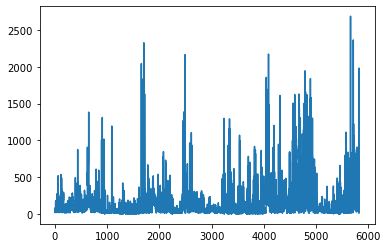

In [164]:
ES_DV['TDV'].plot()

In [165]:
ES_DV.isnull().sum()

level_0           0
index             0
ID                0
year              0
Leg               0
Day of Week       0
month             0
matched_seg_id    0
Lat               0
Long              0
TDV               0
dtype: int64

In [166]:
anomally=ES_DV.loc[ES_DV['TDV']>4000]
anomally

,level_0,index,ID,year,Leg,Day of Week,month,matched_seg_id,Lat,Long,TDV


In [167]:
an1=sc.loc[sc['ID']=='Miovision81']
an1.head()

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,ID,Date,Day of Week,Start Time,End Time,Count,Leg,...,dayofweek,weekday_Status,Week Day Status,starttime,endtime,starttime1,endtime1,startDateTime,endDateTime,diff
8023,32670,32670,2495,Miovision81,2017-06-04,Sunday,6:00 AM,7:00 AM,1141,N,...,6.0,1,Weekend,06:00:00,07:00:00,NaN,NaN,2017-06-04 06:00:00,2017-06-04 07:00:00,1.0
8024,32671,32671,2496,Miovision81,2017-06-04,Sunday,7:00 AM,8:00 AM,1081,N,...,6.0,1,Weekend,07:00:00,08:00:00,NaN,NaN,2017-06-04 07:00:00,2017-06-04 08:00:00,1.0
8025,32672,32672,2497,Miovision81,2017-06-04,Sunday,8:00 AM,9:00 AM,81,N,...,6.0,1,Weekend,08:00:00,09:00:00,NaN,NaN,2017-06-04 08:00:00,2017-06-04 09:00:00,1.0
8026,32673,32673,2498,Miovision81,2017-06-04,Sunday,9:00 AM,10:00 AM,28,N,...,6.0,1,Weekend,09:00:00,10:00:00,NaN,NaN,2017-06-04 09:00:00,2017-06-04 10:00:00,1.0
8027,32674,32674,2499,Miovision81,2017-06-04,Sunday,10:00 AM,11:00 AM,17,N,...,6.0,1,Weekend,10:00:00,11:00:00,NaN,NaN,2017-06-04 10:00:00,2017-06-04 11:00:00,1.0


In [168]:
ES_DV.to_csv('C:/UC Berkeley Project Backup/Bike_ped Exposure Model Project/Estimated_Outcomes/Revised_Estimated_SC_DV.csv',index=False)

# End of the Code